## Base de datos
[Base de datos usada](https://archive.ics.uci.edu/ml/datasets/Power+consumption+of+Tetouan+city)


In [1]:
#!wget https://raw.githubusercontent.com/programanime/modelos2_power_consumption_tetouan_city/main/data/tetuan_city_power_consumption.csv -O tetuan_city_power_consumption.csv

> #EDA (Exploratory Data Analysis)
> ## Limpieza del dataset
1. se carga la base de datos.
2. se hace un primer análisis dimensional, identificando el número de características y muestras.
3. se identifican valores nulos con el fin de eliminar dichos registros o hacer imputación de datos.
4. se transforman las columnas a sus tipos respectivos, bien sea float64, datetime u otro tipo.

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
import numpy as np
import warnings
import time
warnings.filterwarnings('ignore')
x_columns = ["Month","DayWeek","Hour","Temperature", "Humidity", "Wind Speed", "general diffuse flows", "diffuse flows"]
y_column_zona_1 = "Zone 1 Power Consumption"
y_column_zona_2 = "Zone 2  Power Consumption"
y_column_zona_3 = "Zone 3  Power Consumption"
y_columns = [y_column_zona_1, y_column_zona_2, y_column_zona_3]
KFOLD_NSPLITS = 3
pd.set_option('display.max_rows', 500)


In [3]:
import pandas as pd
df = pd.read_csv("tetuan_city_power_consumption.csv")
df.shape

(52416, 9)

>- Total muestras = 52416

>Aunque el total de columnas es igual a 9, en realidad solo contamos con 6 características, ya que las últimas 3 columnas corresponden a variables de salida que representan el consumo de energía para cada una de las zonas respectivas: 1,2 y 3.

- Total características = 6
- Total variables de salida = 3

$$ M=6 $$
$$ N=52416 $$


In [4]:
df.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


>nuestra lista de características es :
- DateTime
- Temperature
- Humidity
- Wind Speed
- general diffuse flows
- diffuse flows

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DateTime                   52416 non-null  object 
 1   Temperature                52416 non-null  float64
 2   Humidity                   52416 non-null  float64
 3   Wind Speed                 52416 non-null  float64
 4   general diffuse flows      52416 non-null  float64
 5   diffuse flows              52416 non-null  float64
 6   Zone 1 Power Consumption   52416 non-null  float64
 7   Zone 2  Power Consumption  52416 non-null  float64
 8   Zone 3  Power Consumption  52416 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


>Para este caso en específico no se tienen valores nulos en ninguna de las características, por tanto, no se considera necesario hacer un proceso de imputación.

In [6]:
df["DateTime"] = pd.to_datetime(df["DateTime"])
df["Month"] = df["DateTime"].dt.month
df["Day"] = df["DateTime"].dt.day
df["DayWeek"] = df["DateTime"].dt.dayofweek
df["Hour"] = df["DateTime"].dt.hour

>Hacemos la transformación de la característica "DateTime" a su correspondiente tipo.

> debido a que no se tienen variables de tipo categórico u ordinal, no hay necesidad de crear variables dummy o aplicar Encoders

# Análisis de las características

<AxesSubplot: >

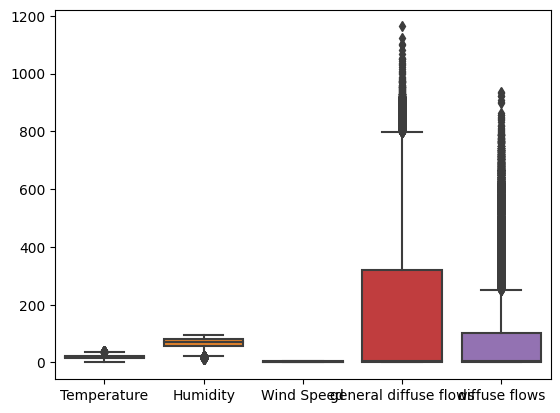

In [7]:
import seaborn as sns
plt.clf()
sns.boxplot(data=df[["Temperature", "Humidity", "Wind Speed", "general diffuse flows", "diffuse flows"]])

In [8]:
def describir_variable_con_graficas(feature):
  import numpy as np
  fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

  mean = df[feature].mean()
  mode = df[feature].mode()[0]
  median = df[feature].median()
  range = np.abs(df[feature].max() - df[feature].min())
  iqr = np.subtract(*np.percentile(df[feature], [75, 25]))
  std = df[feature].std()

  fig.suptitle(f'Descripción estadística de la variable {feature}')
  sns.boxplot(ax=axes[0], data=df, x=feature)
  sns.distplot(df[feature], ax=axes[1])
  #sns.kdeplot(df[feature], ax=axes[1, 0])
  axes[1].axvline(mean,0,1, c="red")
  axes[1].text(mean,0,'  media',rotation=90)

  axes[1].axvline(median,0,1, c="green")
  axes[1].text(median,0,'  median',rotation=90)

  axes[1].axvline(mode,0,1,  c="blue")
  axes[1].text(mode,0,'  mode',rotation=90)
  # axes[0].set_title(f"Diagrama de bigotes de la variable {feature}")
  # axes[1].set_title(f"Distribución de la variable {feature}")
  # sns.violinplot(ax=axes[1, 1], data=df, x='Temperature')
  print(f"media : {mean}")
  print(f"mediana : {median}")
  print(f"mode : {mode}")
  print(f"range : {range}")
  print(f"iqr : {iqr}")
  print(f"std : {std}")
  



media : 18.81002396214896
mediana : 18.78
mode : 15.18
range : 36.763
iqr : 8.48
std : 5.8154758389084265


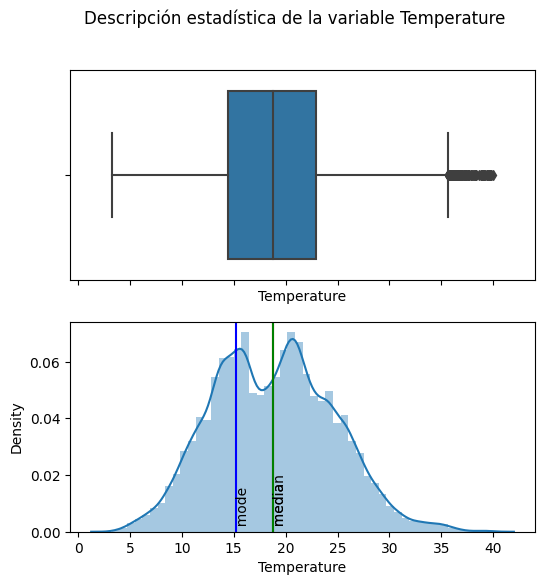

In [9]:
describir_variable_con_graficas("Temperature")

# Descripción de la variable "Temperature"
1. Rango: 36.7
2. Media: 18.81
3. Moda:  15.18
4. Mediana: 18.78
5. Tipo de distribución: Bimodal
6. Outliers: no posee outliers representativos.
7. Rango intercuartílico: 8.48
8. std: 5.81

media : 68.25951846764346
mediana : 69.86
mode : 85.9
range : 83.46
iqr : 23.090000000000003
std : 15.551177174321182


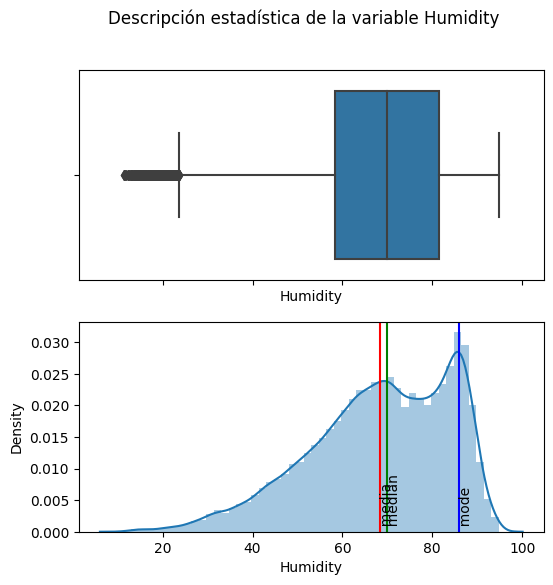

In [10]:
describir_variable_con_graficas("Humidity")

# Descripción de la variable "Humidity"
1. Rango: 83.46
2. Media: 68.25
3. Moda:  85.9
4. Mediana: 69.86
5. Tipo de distribución: en este caso contamos con una distribución asimetrica negativa
6. Outliers: hay gran cantidad de outliers a la izquierda, representando humedades extremadamente bajas, posible consecuencia de un aumento en la temperatura
7. Rango intercuartílico: 23.09
8. std: 15.55

media : 1.9594888583638583
mediana : 0.086
mode : 0.082
range : 6.433
iqr : 4.837
std : 2.348861953883838


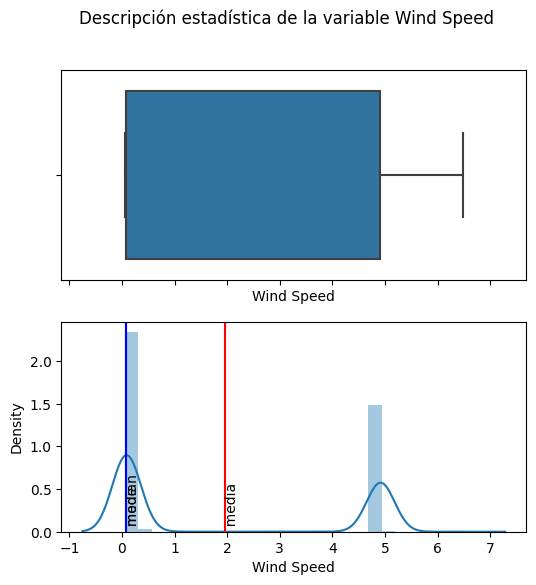

In [11]:
describir_variable_con_graficas("Wind Speed")

# Descripcion de la variable "Win Speed"
1. Rango:  6.433
2. Media: 1.96
3. Moda:  0.08
4. Mediana: 0.09
5. Tipo de distribucion: Bimodal, con una moda muy cerca de "0" y otra moda muy cerca de "5"
6. Outliers: En este caso no cuenta con outliers
7. Rango intercuartilico: 4.837
8. std: 2.34

media : 182.69661376297316
mediana : 5.0355
mode : 0.055
range : 1162.996
iqr : 319.538
std : 264.4009596680264


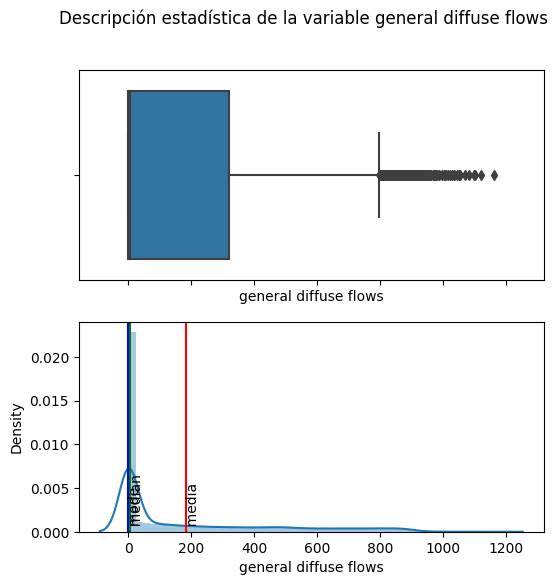

In [12]:
describir_variable_con_graficas("general diffuse flows")

# Descripcion de la variable "general diffuse flows"
1. Rango:  1162.99
2. Media: 182.69
3. Moda:  0.05
4. Mediana: 5.03
5. Tipo de distribucion: Asimetrica positiva
6. Outliers: En este caso se tienen una gran cantidad de outliers a la derecha, una posible causa es una alta variacion en la temperatura.
7. Rango intercuartilico: 319.53
8. std: 264.40

media : 75.02802192078755
mediana : 4.4559999999999995
mode : 0.115
range : 935.989
iqr : 100.878
std : 124.2109493296941


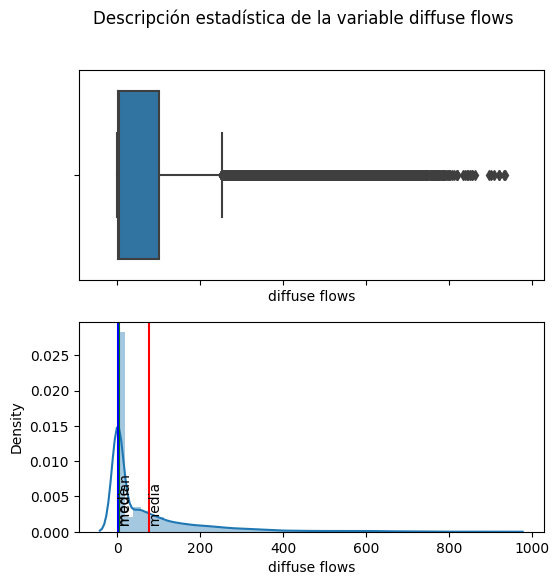

In [13]:
describir_variable_con_graficas("diffuse flows")

# Descripcion de la variable "diffuse flows"
1. Rango:  935.98
2. Media: 75.02
3. Moda:  0.11
4. Mediana: 4.45
5. Tipo de distribucion: Asimetrica positiva
6. Outliers: En este caso se tienen una gran cantidad de outliers a la derecha, por ser una medida muy similar a la anterior la causa probable es la variacion en la temperatura.
7. Rango intercuartilico: 100.87
8. std : 124.21



In [14]:
def relacion_entre_caracteristica_y_consumo_por_zona(feature):
  fig, axes = plt.subplots(2, 2, figsize=(18, 10))
  axes[0, 0].scatter(x = df[feature], y = df["Zone 1 Power Consumption"])
  axes[0, 0].set_title(f"Relacion entre {feature} y consumo de zona 1")
  axes[0, 1].scatter(x = df[feature], y = df["Zone 2  Power Consumption"])
  axes[0, 1].set_title(f"Relacion entre {feature} y consumo de zona 2")
  axes[1, 0].scatter(x = df[feature], y = df["Zone 3  Power Consumption"])
  axes[1, 0].set_title(f"Relacion entre {feature} y consumo de zona 3")
  plt.xlabel(feature)
  plt.show()
  
  

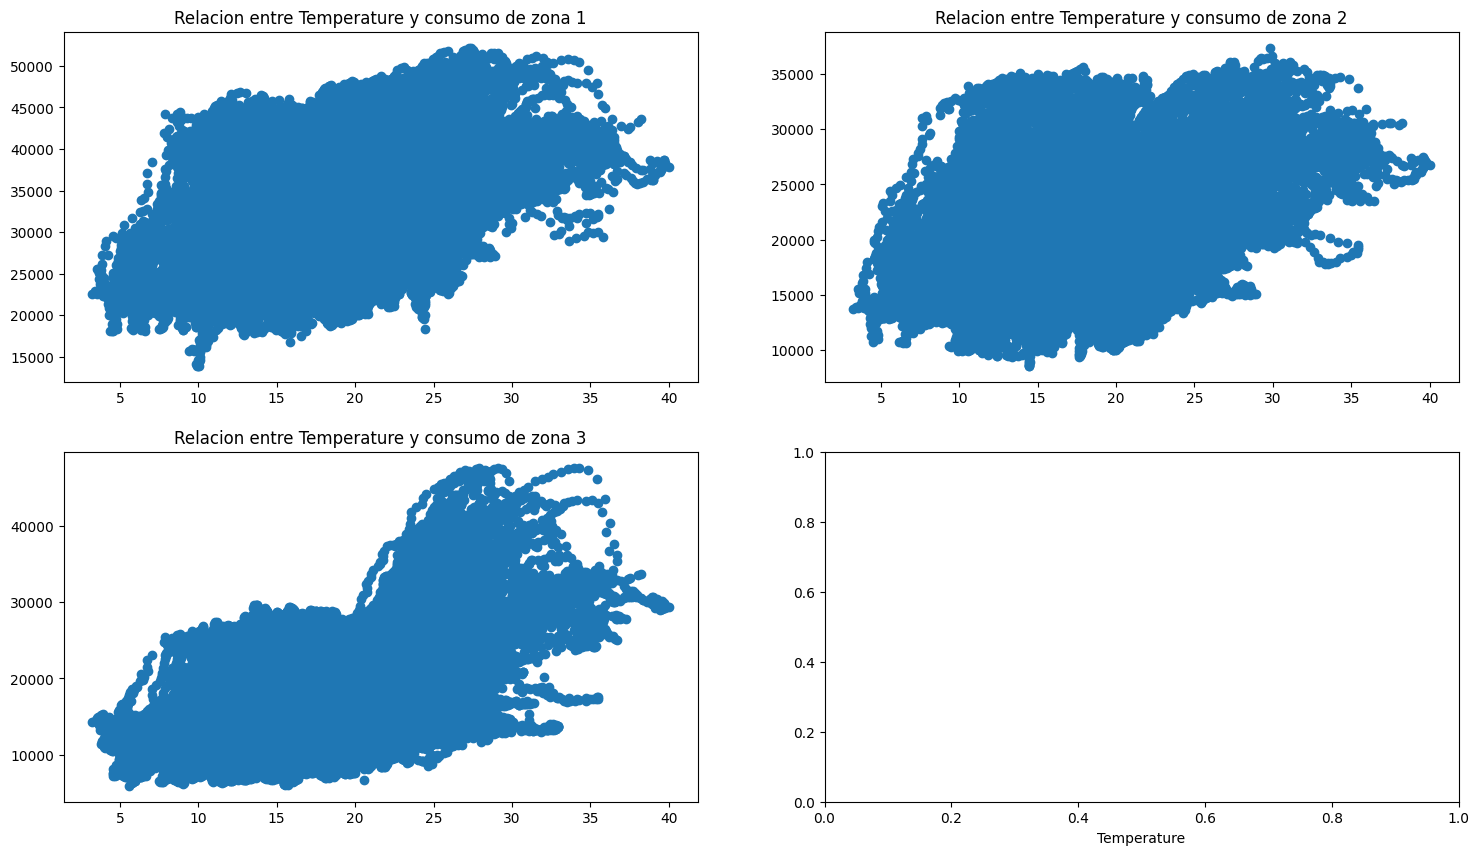

In [15]:
relacion_entre_caracteristica_y_consumo_por_zona("Temperature")

> Analizando las graficas por zona se logra evidenciar que a medida que la temperatura aumenta, el consumo de energia tambien se incrementa, por tanto podriamos decir que existe cierta correlacion positiva entre las variables.

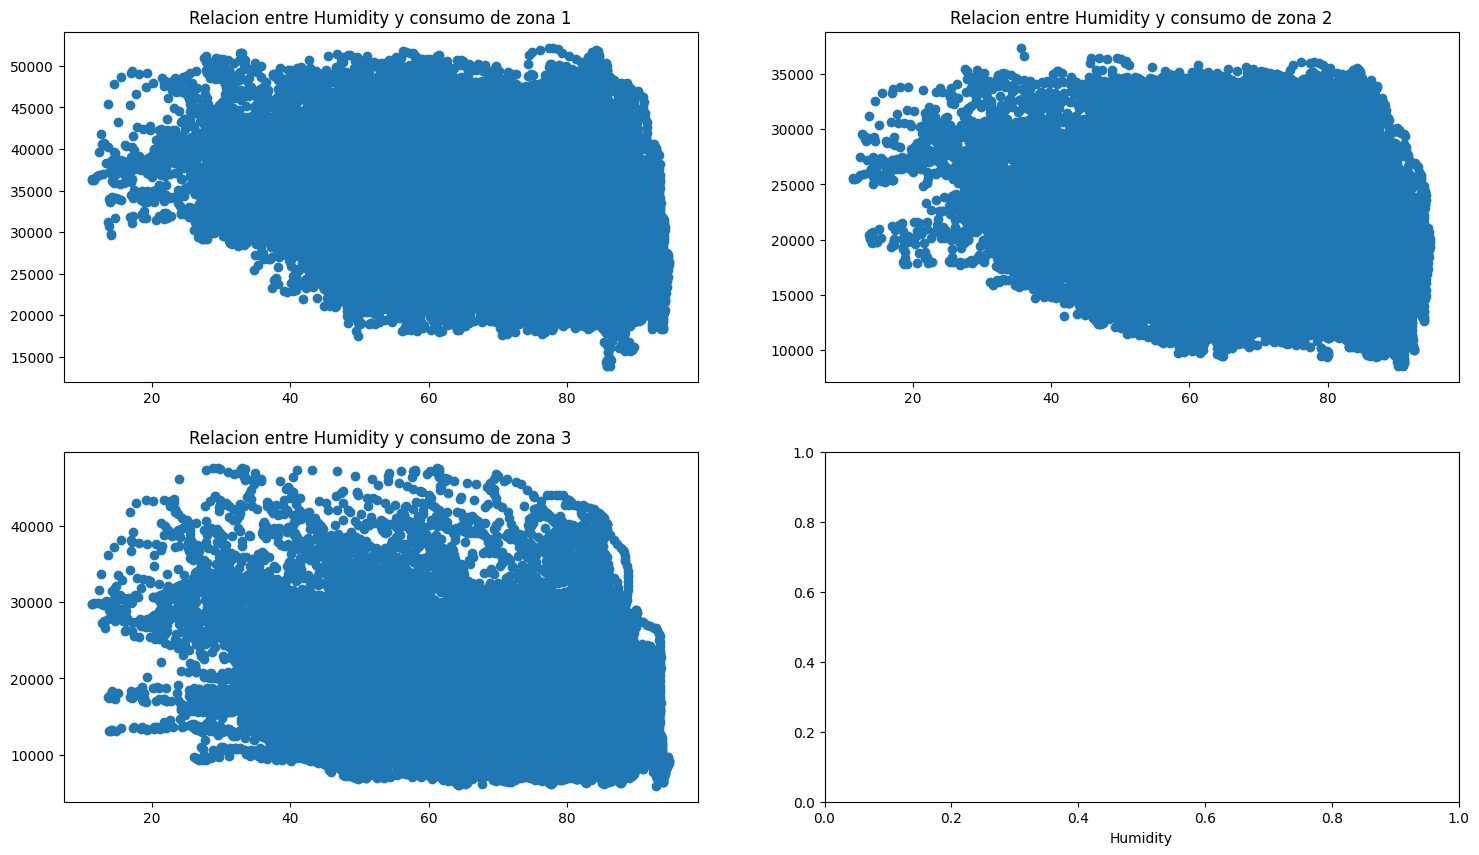

In [16]:
relacion_entre_caracteristica_y_consumo_por_zona("Humidity")

> Analizando las graficas por zona se logra evidenciar que a medida que la humedad aumenta, el consumo de energia disminuye, por tanto podriamos decir que existe cierta correlacion negativa entre las variables.

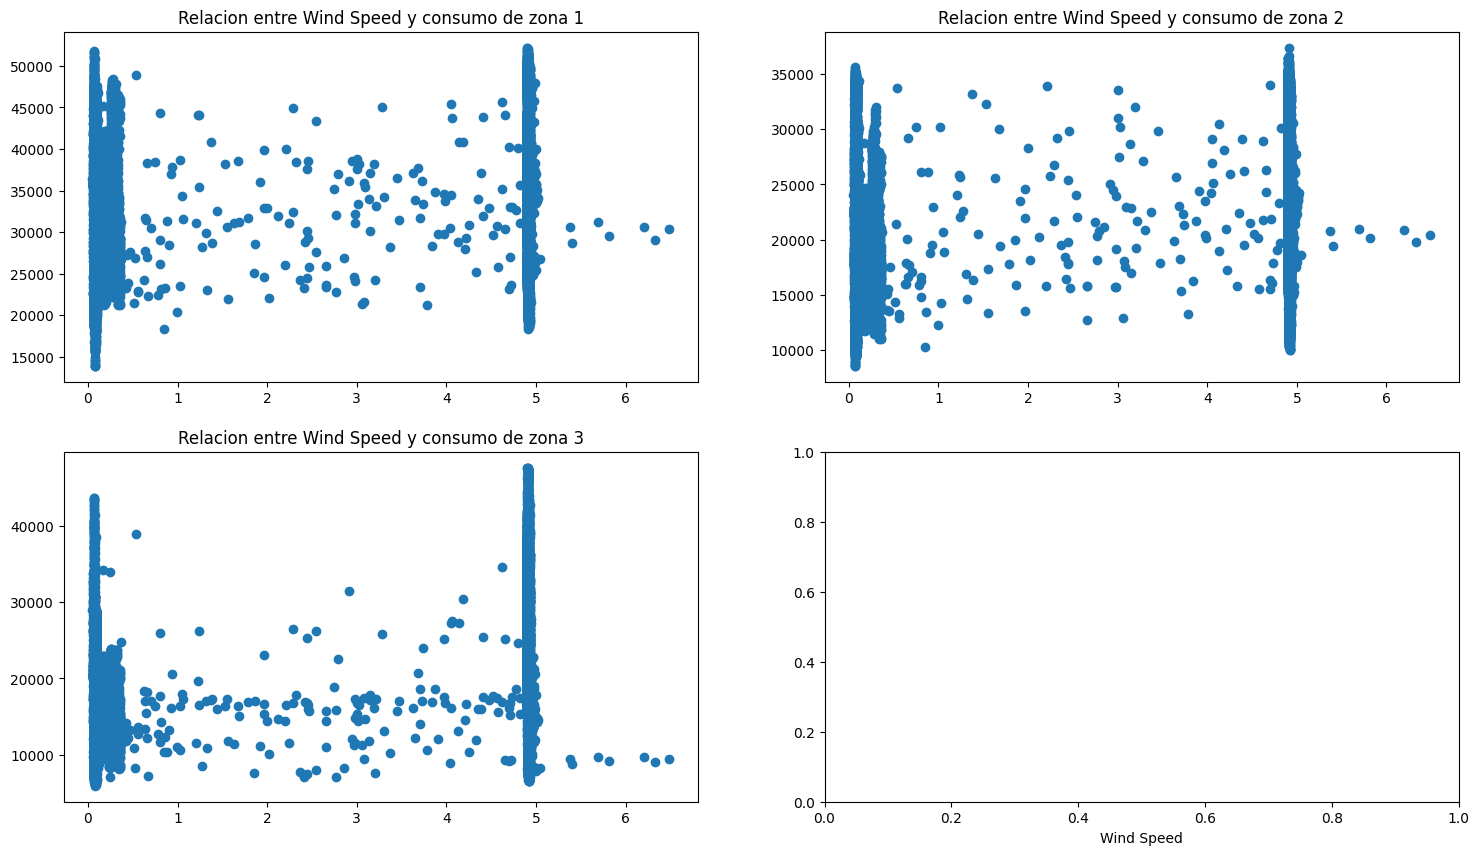

In [17]:
relacion_entre_caracteristica_y_consumo_por_zona("Wind Speed")

> Observando la grafica sobre sus puntos mas representativos (0 y 5 del analisis previamente realizado sobre la variable "win speed"), se puede observar que es totalmente vertical, a simple vista podriamos decir que no existe ninguna relacion entre las variables.

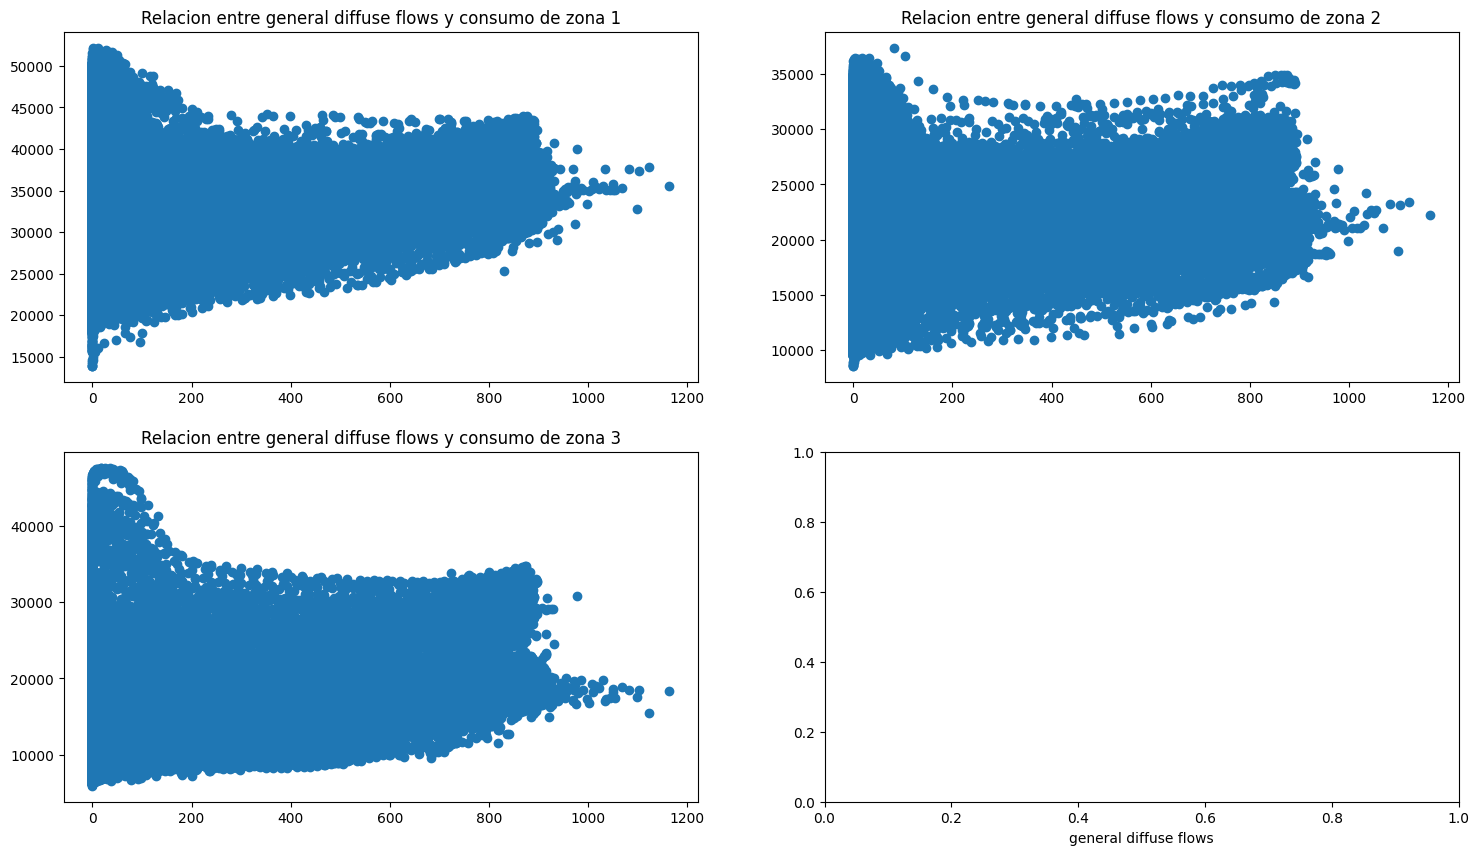

In [18]:
relacion_entre_caracteristica_y_consumo_por_zona("general diffuse flows")

> Analizando las graficas por zona se logra evidenciar que a medida que "general diffuse flows" aumenta, tambien aumenta el consumo de energia, pero tambien hay casos donde "general diffuse flows" es muy bajo y el consumo de energia es alto, por tanto se podria decir que existe cierta correlacion positiva pero no es lineal.

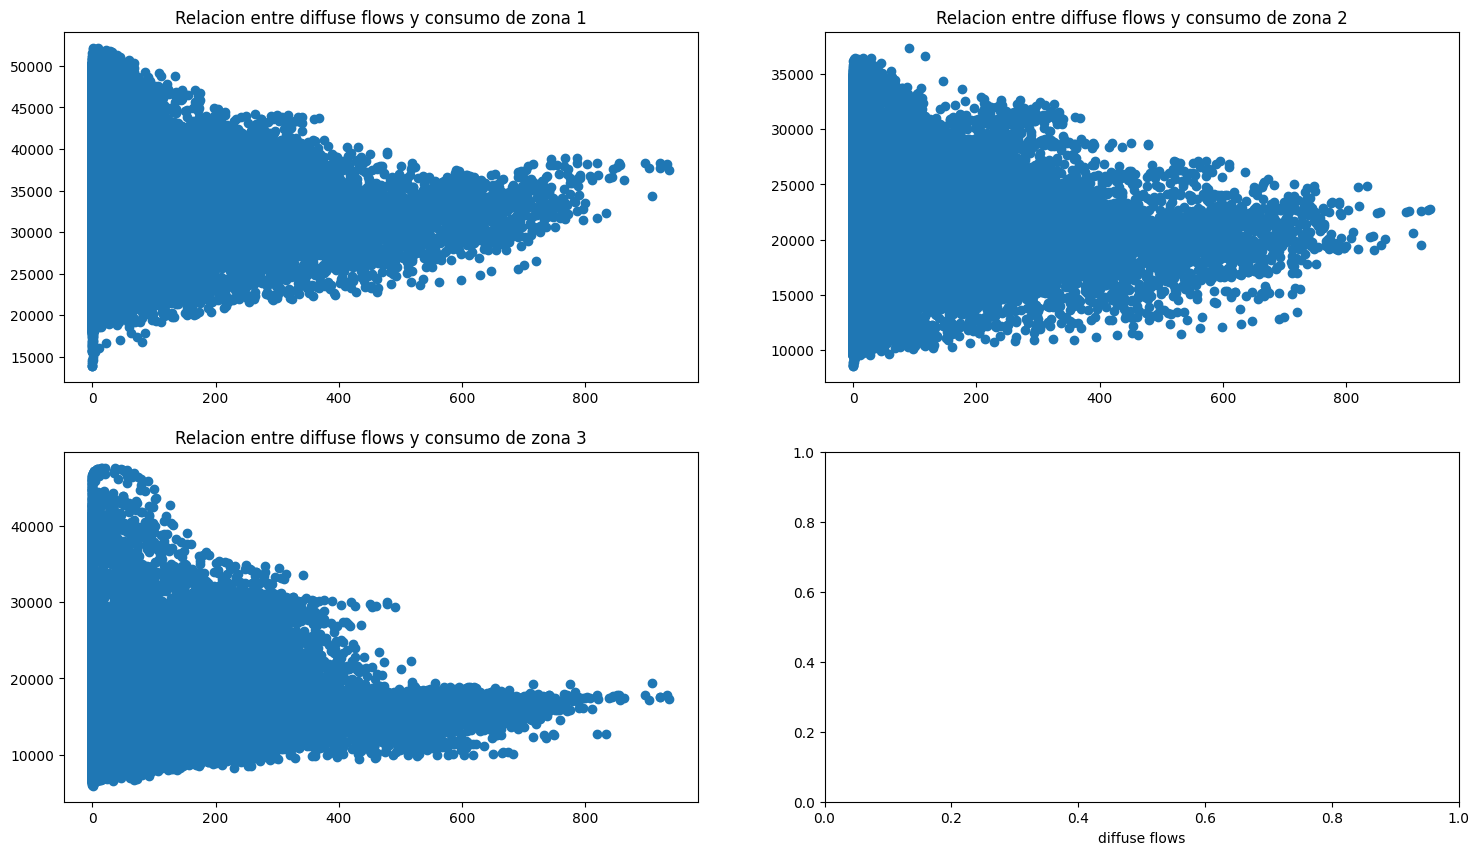

In [19]:
relacion_entre_caracteristica_y_consumo_por_zona("diffuse flows")

> Analizando las graficas por zona se logra evidenciar que a medida que "diffuse flows" aumenta, tambien aumenta el consumo de energia, pero tambien hay casos donde "diffuse flows" es muy bajo y el consumo de energia es alto, por tanto se podria decir que existe cierta correlacion positiva pero no es lineal.

# Normalizacion
una vez se hace limpieza sobre el dataframe se procede a aplicar la normalizacion de cada caracteristica, es importante hacer este procedimiento  para asegurar que todos las variables independientes de nuestro modelo esten en la misma escala y evitar que una de ellas tenga mayor influencia sobre el modelo solo por tener una escala mayor.
Para cada uno de los casos a continuación se utilizara "StandardScaler"

In [20]:
def normalizar(Xtrain, Xtest=None):
  scaler = StandardScaler()
  scaler.fit(Xtrain)
  Xtrain = scaler.transform(Xtrain)
  if Xtest:
    Xtest = scaler.transform(Xtest)
    return (Xtrain, Xtest)
  return Xtrain

In [21]:
normalizar(df[["Temperature", "Humidity", "Wind Speed", "general diffuse flows", "diffuse flows"]])

array([[-2.10664461,  0.35627749, -0.7989004 , -0.69079687, -0.60308481],
       [-2.13157832,  0.40129059, -0.7989004 , -0.69072501, -0.60335854],
       [-2.14894594,  0.40129059, -0.80017763, -0.69075527, -0.60323777],
       ...,
       [-2.0480074 ,  0.29197306, -0.79762318, -0.69067206, -0.6034471 ],
       [-2.07242524,  0.30483395, -0.80017763, -0.69074014, -0.60332633],
       [-2.10303352,  0.37556882, -0.79975189, -0.69075527, -0.60314921]])

al hacer una prueba de la normalizacion de las caracteristicas se evidencia que todas estan en la misma escala

# Modelo Regresión Multiple

In [22]:
def regresion_multiple(df, x_columns, y_column):
  start_time = time.perf_counter()
  X = df[x_columns].to_numpy()
  Y = df[y_column].to_numpy()

  kf = KFold(n_splits=KFOLD_NSPLITS)

  rendimiento_test=[]
  rscore = []
  
  for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    regr = linear_model.LinearRegression()
    regr.fit(X_train, Y_train)
    Y_pred = regr.predict(X_test)

    r2 = r2_score(Y_test, Y_pred)  
    mape = mean_absolute_percentage_error(y_true = Y_test, y_pred = Y_pred)

    rscore.append(r2)
    rendimiento_test.append(mape)  
    duration = (time.perf_counter() - start_time)/60
  return (np.mean(rscore), np.mean(rendimiento_test), np.std(rendimiento_test), duration)

In [23]:
resultados_regresion_multiple = pd.DataFrame()
idx = 0
for y_column in y_columns:
    idx = idx + 1
    r2, mape, intervalo_confianza, duration = regresion_multiple(df, x_columns, y_column)
    resultados_regresion_multiple.loc[idx,'zona'] = y_column
    resultados_regresion_multiple.loc[idx,'r2'] = r2
    resultados_regresion_multiple.loc[idx,'mape'] = mape
    resultados_regresion_multiple.loc[idx,'intervalo_confianza'] = intervalo_confianza
    resultados_regresion_multiple.loc[idx,'duration (m)'] = duration
    print(f"y_column: {y_column}, r2: {r2}, mape: {mape}, intervalo_confianza: {intervalo_confianza}, duration: {duration}")
resultados_regresion_multiple

y_column: Zone 1 Power Consumption, r2: 0.523609992126895, mape: 0.12566229670166917, intervalo_confianza: 0.012094744139869482, duration: 0.0012520166666945443
y_column: Zone 2  Power Consumption, r2: 0.3277679131527932, mape: 0.14575955517484754, intervalo_confianza: 0.013714496477377923, duration: 0.001146580000446799
y_column: Zone 3  Power Consumption, r2: -1.9640403018100603, mape: 0.39148899135313514, intervalo_confianza: 0.23835393103083363, duration: 0.001102580000103141


,zona,r2,mape,intervalo_confianza,duration (m)
1,Zone 1 Power Consumption,0.523610,0.125662,0.012095,0.001252
2,Zone 2 Power Consumption,0.327768,0.145760,0.013714,0.001147
3,Zone 3 Power Consumption,-1.964040,0.391489,0.238354,0.001103


# Modelo Ventana Parzen

In [24]:
def kernel_gaussiano(x):
    return (np.exp((-0.5)*x**2))
    

def Nadaraya_Watson(h, Xtrain, Ytrain, Xtest):
    N = Xtrain.shape[0]
    distancias = np.zeros(N)
    Yest = np.zeros(Xtest.shape[0])
    for j in range(Xtest.shape[0]):
      for i in range(N):
        distancias[i] = np.sqrt(np.sum((Xtest[j,:] - Xtrain[i, :])**2))
      kernel = kernel_gaussiano(distancias / h)
      Yest[j] = (kernel.T @ Ytrain) / np.sum(kernel)
    
    return Yest

def ventana_parzen(df, x_columns, y_column, h):
  start_time = time.perf_counter()
  X=df[x_columns].to_numpy()
  Y=df[y_column].to_numpy()

  kf = KFold(n_splits=KFOLD_NSPLITS)

  rendimiento_test=[]
  rscore = []
  
  for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    Y_pred = Nadaraya_Watson(h, X_train, Y_train, X_test)
            
    r2 = r2_score(Y_test, Y_pred)  
    mape = mean_absolute_percentage_error(y_true = Y_test, y_pred = Y_pred)

    rscore.append(r2)
    rendimiento_test.append(mape)  

  duration = (time.perf_counter() - start_time)/60
  
  return (np.mean(rscore), np.mean(rendimiento_test), np.std(rendimiento_test), duration)


In [25]:
# df.columns.values
# resultados = pd.DataFrame()
# idx = 0
# for y_column in y_columns:
#     for h in [1,2,3,5]:
#         idx = idx + 1
#         r2, mape, intervalo_confianza, duration= ventana_parzen(df, x_columns, y_column, h)
#         resultados.loc[idx,'zona'] = y_column
#         resultados.loc[idx,'h'] = h
#         resultados.loc[idx,'r2'] = r2
#         resultados.loc[idx,'mape'] = mape
#         resultados.loc[idx,'intervalo_confianza'] = intervalo_confianza
#         resultados.loc[idx,'duration (m)'] = duration
#         print(f"y_column: {y_column}, h: {h}, r2: {r2}, mape: {mape}, intervalo_confianza: {intervalo_confianza} , duration: {duration}")
# resultados

# Modelo RandomForestRegressor

In [26]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

def random_forest(df, x_columns, y_column, n_estimators = 10, max_features=2):
  start_time = time.perf_counter()
  df = df.sample(frac=1)
  X = df[x_columns].to_numpy()
  Y = df[y_column].to_numpy()

  kf = KFold(n_splits=KFOLD_NSPLITS)

  rendimiento_test=[]
  rscore = []
  
  for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    clf = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features)
    clf.fit(X_train, Y_train)
    y_pred = clf.predict(X_test)

    r2 = r2_score(Y_test, y_pred)  
    mape = mean_absolute_percentage_error(y_true = Y_test, y_pred = y_pred)

    rscore.append(r2)
    rendimiento_test.append(mape)  
  duration = (time.perf_counter() - start_time)/60
  return (np.mean(rscore), np.mean(rendimiento_test), np.std(rendimiento_test), duration)
  

In [27]:
df.columns.values

array(['DateTime', 'Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows',
       'Zone 1 Power Consumption', 'Zone 2  Power Consumption',
       'Zone 3  Power Consumption', 'Month', 'Day', 'DayWeek', 'Hour'],
      dtype=object)

In [28]:
df.columns.values
resultados_rf = pd.DataFrame()
idx = 0
for y_column in y_columns:
    for n_estimators in [5,10,15,20]:
        for max_features in [2,3,4,5]:
            idx = idx + 1
            r2, mape, intervalo_confianza, duration = random_forest(df, x_columns, y_column, n_estimators, max_features)
            resultados_rf.loc[idx,'zona'] = y_column
            resultados_rf.loc[idx,'max_features'] = max_features
            resultados_rf.loc[idx,'n_estimators'] = n_estimators
            resultados_rf.loc[idx,'r2'] = r2
            resultados_rf.loc[idx,'mape'] = mape
            resultados_rf.loc[idx,'intervalo_confianza'] = intervalo_confianza
            resultados_rf.loc[idx,'duration (m)'] = duration
            print(f"y_column: {y_column}, n_estimators: {n_estimators}, max_features: {max_features}, r2: {r2}, mape: {mape}, intervalo_confianza: {intervalo_confianza}, duration: {duration}")
resultados_rf

y_column: Zone 1 Power Consumption, n_estimators: 5, max_features: 2, r2: 0.9544183562009992, mape: 0.03330058393604111, intervalo_confianza: 0.0004621994947774319, duration: 0.015066078333378148
y_column: Zone 1 Power Consumption, n_estimators: 5, max_features: 3, r2: 0.9617464354158173, mape: 0.029781761502511814, intervalo_confianza: 0.00014235314095718457, duration: 0.01936387166691323
y_column: Zone 1 Power Consumption, n_estimators: 5, max_features: 4, r2: 0.9665131881411089, mape: 0.027997541994027236, intervalo_confianza: 0.00014090615223463941, duration: 0.022383516666983874
y_column: Zone 1 Power Consumption, n_estimators: 5, max_features: 5, r2: 0.9671506459408198, mape: 0.027425137915327965, intervalo_confianza: 0.0003202552260240296, duration: 0.025746225000087483
y_column: Zone 1 Power Consumption, n_estimators: 10, max_features: 2, r2: 0.9619672149310148, mape: 0.030812609189488777, intervalo_confianza: 0.0005475650722932885, duration: 0.030433453333292466
y_column: Zone

,zona,max_features,n_estimators,r2,mape,intervalo_confianza,duration (m)
1,Zone 1 Power Consumption,2.0,5.0,0.954418,0.033301,0.000462,0.015066
2,Zone 1 Power Consumption,3.0,5.0,0.961746,0.029782,0.000142,0.019364
3,Zone 1 Power Consumption,4.0,5.0,0.966513,0.027998,0.000141,0.022384
4,Zone 1 Power Consumption,5.0,5.0,0.967151,0.027425,0.000320,0.025746
5,Zone 1 Power Consumption,2.0,10.0,0.961967,0.030813,0.000548,0.030433
6,Zone 1 Power Consumption,3.0,10.0,0.969179,0.027317,0.000187,0.037192
7,Zone 1 Power Consumption,4.0,10.0,0.970525,0.026321,0.000164,0.044084
8,Zone 1 Power Consumption,5.0,10.0,0.971268,0.025765,0.000118,0.051497
9,Zone 1 Power Consumption,2.0,15.0,0.966922,0.028779,0.000451,0.044131
10,Zone 1 Power Consumption,3.0,15.0,0.970845,0.026533,0.000210,0.056376


In [29]:
df.columns.values

array(['DateTime', 'Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows',
       'Zone 1 Power Consumption', 'Zone 2  Power Consumption',
       'Zone 3  Power Consumption', 'Month', 'Day', 'DayWeek', 'Hour'],
      dtype=object)

# Modelo Redes Neuronales Artificiales

In [30]:
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

def redes_neuronales_artificiales(df, x_columns, y_column, num_hidden_layers=(10,), activation='relu'):
  start_time = time.perf_counter()
  X = df[x_columns].to_numpy()
  Y = df[y_column].to_numpy()

  kf = KFold(n_splits=KFOLD_NSPLITS)

  rendimiento_test=[]
  rscore = []
  
  for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    clf = MLPRegressor(hidden_layer_sizes=num_hidden_layers, activation=activation, max_iter=300)
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    
    r2 = r2_score(Y_test, Y_pred)  
    mape = mean_absolute_percentage_error(y_true = Y_test, y_pred = Y_pred)

    rscore.append(r2)
    rendimiento_test.append(mape)  
  duration = (time.perf_counter() - start_time)/60
  return (np.mean(rscore), np.mean(rendimiento_test), np.std(rendimiento_test), duration)

In [31]:
df.columns.values
resultados_rn = pd.DataFrame()
idx = 0
for y_column in y_columns:
    for activation in ["tanh", "relu"]:
        for neurons in [8,16]:
            for hidden_layers in [1,3]:
                idx = idx + 1
                hidden_layer_sizes = tuple(hidden_layers*[neurons])
                r2, mape, intervalo_confianza, duration = redes_neuronales_artificiales(df, x_columns, y_column, hidden_layer_sizes, activation)
                resultados_rn.loc[idx,'zona'] = y_column
                resultados_rn.loc[idx,'activation'] = activation
                resultados_rn.loc[idx,'neurons'] = neurons
                resultados_rn.loc[idx,'hidden_layers'] = hidden_layers
                resultados_rn.loc[idx,'r2'] = r2
                resultados_rn.loc[idx,'mape'] = mape
                resultados_rn.loc[idx,'intervalo_confianza'] = intervalo_confianza
                resultados_rn.loc[idx,'duration (m)'] = duration
                print(f"zona : {y_column} - activation : {activation} - neurons : {neurons} - hidden_layers : {hidden_layers} - r2 : {r2} - mape : {mape} - intervalo_confianza : {intervalo_confianza}, duration: {duration}")
resultados_rn

zona : Zone 1 Power Consumption - activation : tanh - neurons : 8 - hidden_layers : 1 - r2 : -21.337545166944167 - mape : 0.9843934129771569 - intervalo_confianza : 0.000856179746702845, duration: 0.4736632766667753
zona : Zone 1 Power Consumption - activation : tanh - neurons : 8 - hidden_layers : 3 - r2 : -21.3414952421758 - mape : 0.9844875617362016 - intervalo_confianza : 0.0008771169291457669, duration: 0.9099158883327618
zona : Zone 1 Power Consumption - activation : tanh - neurons : 16 - hidden_layers : 1 - r2 : -20.771186919083174 - mape : 0.9705547869731902 - intervalo_confianza : 0.0016128133175185692, duration: 0.565139158332992
zona : Zone 1 Power Consumption - activation : tanh - neurons : 16 - hidden_layers : 3 - r2 : -20.780795032144336 - mape : 0.9707922948304665 - intervalo_confianza : 0.0015839535390332025, duration: 1.1143384166673058
zona : Zone 1 Power Consumption - activation : relu - neurons : 8 - hidden_layers : 1 - r2 : -0.8716965096593272 - mape : 0.2278171352

,zona,activation,neurons,hidden_layers,r2,mape,intervalo_confianza,duration (m)
1,Zone 1 Power Consumption,tanh,8.0,1.0,-21.337545,0.984393,0.000856,0.473663
2,Zone 1 Power Consumption,tanh,8.0,3.0,-21.341495,0.984488,0.000877,0.909916
3,Zone 1 Power Consumption,tanh,16.0,1.0,-20.771187,0.970555,0.001613,0.565139
4,Zone 1 Power Consumption,tanh,16.0,3.0,-20.780795,0.970792,0.001584,1.114338
5,Zone 1 Power Consumption,relu,8.0,1.0,-0.871697,0.227817,0.067690,0.473761
6,Zone 1 Power Consumption,relu,8.0,3.0,0.040520,0.178687,0.079405,0.852150
7,Zone 1 Power Consumption,relu,16.0,1.0,-0.056950,0.181578,0.033315,0.543041
8,Zone 1 Power Consumption,relu,16.0,3.0,0.086079,0.175132,0.073675,1.094291
9,Zone 2 Power Consumption,tanh,8.0,1.0,-17.795792,0.975670,0.002132,0.472166
10,Zone 2 Power Consumption,tanh,8.0,3.0,-17.803509,0.975893,0.002100,0.894325


# Modelo SVM con rbf

In [32]:
from sklearn.svm import SVR
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold


def regresion_con_soporte_de_vectores_por_kernel_rbf(df, x_columns, y_column, kernel='rbf', gamma='auto'):
  start_time = time.perf_counter()
  rendimiento_test=[]
  rscore = []
  
  df = df.sample(frac=1)
  X = df[x_columns].to_numpy()
  Y = df[y_column].to_numpy()
  kf = KFold(n_splits=KFOLD_NSPLITS)

  for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X=X_train)
    X_test = scaler.transform(X=X_test)

    clf = SVR(kernel=kernel, gamma=gamma)
    clf.fit(X_train, Y_train)
    y_pred = clf.predict(X_test)

    r2 = r2_score(Y_test, y_pred)  
    mape = mean_absolute_percentage_error(y_true = Y_test, y_pred = y_pred)

    rscore.append(r2)
    rendimiento_test.append(mape)  
  duration = (time.perf_counter() - start_time)/60
  return (np.mean(rscore), np.mean(rendimiento_test), np.std(rendimiento_test), duration)


In [33]:
df.columns.values
resultados_svm = pd.DataFrame()
idx = 0
for y_column in y_columns:
    for kernel in ["rbf", "linear", "poly"]:
        for gamma in ["auto", "scale"]:
            idx = idx + 1
            r2, mape, intervalo_confianza, duration = regresion_con_soporte_de_vectores_por_kernel_rbf(df, x_columns, y_column, kernel, gamma)
            resultados_svm.loc[idx,'zona'] = y_column
            resultados_svm.loc[idx,'kernel'] = kernel
            resultados_svm.loc[idx,'gamma'] = gamma
            resultados_svm.loc[idx,'r2'] = r2
            resultados_svm.loc[idx,'mape'] = mape
            resultados_svm.loc[idx,'intervalo_confianza'] = intervalo_confianza
            resultados_svm.loc[idx,'duration (m)'] = duration
            print(f"zona : {y_column}, kernel : {kernel}, gamma : {gamma}, r2 : {r2}, mape : {mape}, intervalo_confianza : {intervalo_confianza}, duration: {duration}")
resultados_svm

zona : Zone 1 Power Consumption, kernel : rbf, gamma : auto, r2 : 0.2877205893988766, mape : 0.15657210413188413, intervalo_confianza : 0.00014636354103835498, duration: 5.1311895566662615
zona : Zone 1 Power Consumption, kernel : rbf, gamma : scale, r2 : 0.2873536459410117, mape : 0.15662205208650773, intervalo_confianza : 0.0019912624073665434, duration: 5.036627968333778
zona : Zone 1 Power Consumption, kernel : linear, gamma : auto, r2 : 0.6269255571787324, mape : 0.10767141560528333, intervalo_confianza : 0.00026625866966546377, duration: 2.0251769033328553
zona : Zone 1 Power Consumption, kernel : linear, gamma : scale, r2 : 0.6270868694149861, mape : 0.10766417332595206, intervalo_confianza : 0.0004256813485338343, duration: 2.011972394999854
zona : Zone 1 Power Consumption, kernel : poly, gamma : auto, r2 : 0.2402430535881581, mape : 0.15972553736861558, intervalo_confianza : 0.0005518827022300436, duration: 3.050960846666324
zona : Zone 1 Power Consumption, kernel : poly, gamm

,zona,kernel,gamma,r2,mape,intervalo_confianza,duration (m)
1,Zone 1 Power Consumption,rbf,auto,0.287721,0.156572,0.000146,5.131190
2,Zone 1 Power Consumption,rbf,scale,0.287354,0.156622,0.001991,5.036628
3,Zone 1 Power Consumption,linear,auto,0.626926,0.107671,0.000266,2.025177
4,Zone 1 Power Consumption,linear,scale,0.627087,0.107664,0.000426,2.011972
5,Zone 1 Power Consumption,poly,auto,0.240243,0.159726,0.000552,3.050961
6,Zone 1 Power Consumption,poly,scale,0.240197,0.159746,0.000573,3.320738
7,Zone 2 Power Consumption,rbf,auto,0.332379,0.168039,0.000287,4.994771
8,Zone 2 Power Consumption,rbf,scale,0.332242,0.168063,0.001276,4.924226
9,Zone 2 Power Consumption,linear,auto,0.586561,0.128606,0.000426,2.169036
10,Zone 2 Power Consumption,linear,scale,0.586557,0.128619,0.000652,2.076142


# Parte C
## Punto 7
### Analisis de las caracteristicas
por tratarse de un problema de regresion, se utilizara el coeficiente de pearson para determinar la relacion entre las variables independientes y la variable dependiente, para esto se utilizara la libreria "scipy.stats" y se hara un analisis de las caracteristicas mas relevantes para el modelo.

In [34]:
df.head()
df.corr()[["Zone 1 Power Consumption", "Zone 2  Power Consumption", "Zone 3  Power Consumption"]]

,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
Temperature,0.440221,0.382428,0.489527
Humidity,-0.287421,-0.294961,-0.233022
Wind Speed,0.167444,0.146413,0.278641
general diffuse flows,0.187965,0.157223,0.063376
diffuse flows,0.080274,0.044667,-0.038506
Zone 1 Power Consumption,1.000000,0.834519,0.750733
Zone 2 Power Consumption,0.834519,1.000000,0.570932
Zone 3 Power Consumption,0.750733,0.570932,1.000000
Month,-0.005346,0.320266,-0.233926
Day,0.026273,0.052941,-0.004783


Basado en el resultado anterior, las caracteristicas candidatas para ser eliminadas serian (dichas caracteristicas no tienen mayor influencia en las tres variables de salida):
- diffuse flows
- general diffuse flows
- Month
- Day
- DayWeek

se dejaran las otras caracteristicas porque en todos los casos su coeficiente es mayor a 0.1, por lo tanto se considera que tienen una influencia significativa en el modelo.

## Punto 8
nuestros tres mejores modelos fueron:
- Regresión multiple
- Random Forest
- SVM

# SequentialFeatureSelector para Regresion Multiple

In [35]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

def regresion_lineal_con_seleccion_de_atributos(df, x_columns, y_column):
    start_time = time.perf_counter()
    rendimiento_test=[]
    rscore = []
    
    df = df.sample(frac=1)
    X = df[x_columns].to_numpy()
    Y = df[y_column].to_numpy()
    kf = KFold(n_splits=KFOLD_NSPLITS)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
    
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X=X_train)
        X_test = scaler.transform(X=X_test)
    
        sfs = SequentialFeatureSelector(LinearRegression(), n_features_to_select=4, direction='forward', scoring='r2')
        sfs.fit(X_train, Y_train)
        X_train = sfs.transform(X_train)
        X_test = sfs.transform(X_test)
    
        clf = LinearRegression()
        clf.fit(X_train, Y_train)
        y_pred = clf.predict(X_test)
    
        r2 = r2_score(Y_test, y_pred)  
        mape = mean_absolute_percentage_error(y_true = Y_test, y_pred = y_pred)
    
        rscore.append(r2)
        rendimiento_test.append(mape)  
    duration = (time.perf_counter() - start_time)/60
    return (np.mean(rscore), np.mean(rendimiento_test), np.std(rendimiento_test), duration)

In [36]:
resultados_regresion_lineal_multiple_sc = pd.DataFrame()
idx = 0
for y_column in y_columns:
    idx = idx + 1
    r2, mape, intervalo_confianza, duration = regresion_lineal_con_seleccion_de_atributos(df, x_columns, y_column)
    resultados_regresion_lineal_multiple_sc.loc[idx,'zona'] = y_column
    resultados_regresion_lineal_multiple_sc.loc[idx,'r2_new'] = r2
    resultados_regresion_lineal_multiple_sc.loc[idx,'mape'] = mape
    resultados_regresion_lineal_multiple_sc.loc[idx,'intervalo_confianza'] = intervalo_confianza
    resultados_regresion_lineal_multiple_sc.loc[idx,'duration (m)'] = duration
    print(f"y_column: {y_column}, r2: {r2}, mape: {mape}, intervalo_confianza: {intervalo_confianza}, duration: {duration}")
resultados_regresion_lineal_multiple_sc["r2"] = resultados_regresion_multiple["r2"]
resultados_regresion_lineal_multiple_sc["r2_diff"] = resultados_regresion_lineal_multiple_sc["r2_new"] - resultados_regresion_lineal_multiple_sc["r2"]
resultados_regresion_lineal_multiple_sc

y_column: Zone 1 Power Consumption, r2: 0.6388868713767876, mape: 0.10917692124443978, intervalo_confianza: 0.000807395254205503, duration: 0.02734475166653283
y_column: Zone 2  Power Consumption, r2: 0.586717104905566, mape: 0.13153058165284384, intervalo_confianza: 0.0006645178926416151, duration: 0.02652535333278744
y_column: Zone 3  Power Consumption, r2: 0.5799361781000606, mape: 0.20714611922135115, intervalo_confianza: 0.0012638593991086877, duration: 0.027493191666629477


,zona,r2_new,mape,intervalo_confianza,duration (m),r2,r2_diff
1,Zone 1 Power Consumption,0.638887,0.109177,0.000807,0.027345,0.523610,0.115277
2,Zone 2 Power Consumption,0.586717,0.131531,0.000665,0.026525,0.327768,0.258949
3,Zone 3 Power Consumption,0.579936,0.207146,0.001264,0.027493,-1.964040,2.543976


# SequentialFeatureSelector para Random Forest

In [37]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

def bosque_aleatorio_con_seleccion_de_atributos(df, x_columns, y_column, n_estimators = 10, max_features=2):
    start_time = time.perf_counter()
    df = df.sample(frac=1)
    X = df[x_columns].to_numpy()
    Y = df[y_column].to_numpy()

    kf = KFold(n_splits=KFOLD_NSPLITS)

    rendimiento_test=[]
    rscore = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        sfs = SequentialFeatureSelector(RandomForestRegressor(n_estimators=n_estimators, max_features=max_features), n_features_to_select=4, direction='forward', scoring='r2')
        sfs.fit(X_train, Y_train)
        X_train = sfs.transform(X_train)
        X_test = sfs.transform(X_test)

        clf = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features)
        clf.fit(X_train, Y_train)
        y_pred = clf.predict(X_test)

        r2 = r2_score(Y_test, y_pred)  
        mape = mean_absolute_percentage_error(y_true = Y_test, y_pred = y_pred)

        rscore.append(r2)
        rendimiento_test.append(mape)  
    duration = (time.perf_counter() - start_time)/60
    return (np.mean(rscore), np.mean(rendimiento_test), np.std(rendimiento_test), duration)


In [39]:
df.columns.values
resultados_rf_sc = pd.DataFrame()
idx = 0
for y_column in y_columns:
    for n_estimators in [15,20]:
        for max_features in [4,5]:
            idx = idx + 1
            r2, mape, intervalo_confianza, duration = bosque_aleatorio_con_seleccion_de_atributos(df, x_columns, y_column, n_estimators, max_features)
            resultados_rf_sc.loc[idx,'zona'] = y_column
            resultados_rf_sc.loc[idx,'max_features'] = max_features
            resultados_rf_sc.loc[idx,'n_estimators'] = n_estimators
            resultados_rf_sc.loc[idx,'r2_new'] = r2
            resultados_rf_sc.loc[idx,'mape'] = mape
            resultados_rf_sc.loc[idx,'intervalo_confianza'] = intervalo_confianza
            resultados_rf_sc.loc[idx,'duration (m)'] = duration
            print(f"y_column: {y_column}, n_estimators: {n_estimators}, max_features: {max_features}, r2: {r2}, mape: {mape}, intervalo_confianza: {intervalo_confianza}, duration: {duration}")
resultados_rf_sc["r2"] = resultados_rf["rf"]
resultados_rf_sc["r2_diff"] = resultados_rf_sc["r2_new"] - resultados_rf_sc["r2"]

y_column: Zone 1 Power Consumption, n_estimators: 5, max_features: 2, r2: 0.9548214487153651, mape: 0.030154769502536243, intervalo_confianza: 0.00030462844678378823, duration: 0.7224953349999851
y_column: Zone 1 Power Consumption, n_estimators: 5, max_features: 3, r2: 0.9547235221732407, mape: 0.029769508748512922, intervalo_confianza: 0.00030515154458292225, duration: 0.8017596283335782
y_column: Zone 1 Power Consumption, n_estimators: 5, max_features: 4, r2: 0.9530039554824935, mape: 0.030344662324894595, intervalo_confianza: 0.0005265947317720889, duration: 0.8446200299998358
y_column: Zone 1 Power Consumption, n_estimators: 5, max_features: 5, r2: 0.9535956710872879, mape: 0.0301644186166458, intervalo_confianza: 0.00022530060423983658, duration: 0.8428193516670338
y_column: Zone 1 Power Consumption, n_estimators: 10, max_features: 2, r2: 0.9580669807814225, mape: 0.02913955932745733, intervalo_confianza: 0.00042526717436835066, duration: 1.428504256667414
y_column: Zone 1 Power C

# SequentialFeatureSelector para SVM

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

def svm_con_seleccion_de_atributos(df, x_columns, y_column, kernel='rbf', C=1.0, epsilon=0.1):
    start_time = time.perf_counter()
    df = df.sample(frac=1)
    X = df[x_columns].to_numpy()
    Y = df[y_column].to_numpy()

    kf = KFold(n_splits=KFOLD_NSPLITS)

    rendimiento_test=[]
    rscore = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        sfs = SequentialFeatureSelector(SVR(kernel=kernel, C=C, epsilon=epsilon), n_features_to_select=4, direction='forward', scoring='r2')
        sfs.fit(X_train, Y_train)
        X_train = sfs.transform(X_train)
        X_test = sfs.transform(X_test)

        clf = SVR(kernel=kernel, C=C, epsilon=epsilon)
        clf.fit(X_train, Y_train)
        y_pred = clf.predict(X_test)

        r2 = r2_score(Y_test, y_pred)  
        mape = mean_absolute_percentage_error(y_true = Y_test, y_pred = y_pred)

        rscore.append(r2)
        rendimiento_test.append(mape)  
    duration = (time.perf_counter() - start_time)/60
    return (np.mean(rscore), np.mean(rendimiento_test), np.std(rendimiento_test), duration)

In [ ]:
df.columns.values
resultados_svm_sc = pd.DataFrame()
idx = 0
for y_column in y_columns:
    for kernel in ["rbf", "linear", "poly"]:
        for gamma in ["auto", "scale"]:
            idx = idx + 1
            r2, mape, intervalo_confianza, duration = regresion_con_soporte_de_vectores_por_kernel_rbf(df, x_columns, y_column, kernel, gamma)
            resultados_svm_sc.loc[idx,'zona'] = y_column
            resultados_svm_sc.loc[idx,'kernel'] = kernel
            resultados_svm_sc.loc[idx,'gamma'] = gamma
            resultados_svm_sc.loc[idx,'r2_new'] = r2
            resultados_svm_sc.loc[idx,'mape'] = mape
            resultados_svm_sc.loc[idx,'intervalo_confianza'] = intervalo_confianza
            resultados_svm_sc.loc[idx,'duration (m)'] = duration
            print(f"zona : {y_column}, kernel : {kernel}, gamma : {gamma}, r2 : {r2}, mape : {mape}, intervalo_confianza : {intervalo_confianza}, duration: {duration}")
resultados_svm_sc["r2"] =  resultados_svm["r2"]
resultados_svm_sc["r2_diff"] = resultados_svm["r2_new"] - resultados_svm_sc["r2"]
resultados_svm_sc

Entre los criterios utilizados para el algoritmo de seleccion se encuentran:

1. direction = "forward"
2. scoring = "r2"
3. n_features_to_select = 4

se selecciono "r2" como criterio de evaluacion porque es el criterio que se utiliza para evaluar el modelo de regresion multiple.


# Punto 9
nuestros tres mejores modelos fueron:
- Regresión multiple
- Random Forest
- SVM

# PCA para Regresion Multiple

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

def regresion_lineal_con_pca(df, x_columns, y_column):
    start_time = time.perf_counter()
    rendimiento_test=[]
    rscore = []
    
    df = df.sample(frac=1)
    X = df[x_columns].to_numpy()
    Y = df[y_column].to_numpy()
    kf = KFold(n_splits=KFOLD_NSPLITS)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
    
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X=X_train)
        X_test = scaler.transform(X=X_test)
    
        pca = PCA(n_components=4)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
    
        clf = LinearRegression()
        clf.fit(X_train, Y_train)
        y_pred = clf.predict(X_test)
    
        r2 = r2_score(Y_test, y_pred)  
        mape = mean_absolute_percentage_error(y_true = Y_test, y_pred = y_pred)
    
        rscore.append(r2)
        rendimiento_test.append(mape)  
    duration = (time.perf_counter() - start_time)/60
    return (np.mean(rscore), np.mean(rendimiento_test), np.std(rendimiento_test), duration)

In [ ]:
resultados_regresion_lineal_multiple_pca = pd.DataFrame()
idx = 0
for y_column in y_columns:
    idx = idx + 1
    r2, mape, intervalo_confianza, duration = regresion_lineal_con_seleccion_de_atributos(df, x_columns, y_column)
    resultados_regresion_lineal_multiple_pca.loc[idx,'zona'] = y_column
    resultados_regresion_lineal_multiple_pca.loc[idx,'r2_new'] = r2
    resultados_regresion_lineal_multiple_pca.loc[idx,'mape'] = mape
    resultados_regresion_lineal_multiple_pca.loc[idx,'intervalo_confianza'] = intervalo_confianza
    resultados_regresion_lineal_multiple_pca.loc[idx,'duration (m)'] = duration
    print(f"y_column: {y_column}, r2: {r2}, mape: {mape}, intervalo_confianza: {intervalo_confianza}, duration: {duration}")
resultados_regresion_lineal_multiple_pca["r2"] = resultados_regresion_multiple["r2"]
resultados_regresion_lineal_multiple_pca["r2_diff"] = resultados_regresion_lineal_multiple_pca["r2_new"] - resultados_regresion_lineal_multiple_pca["r2"]
resultados_regresion_lineal_multiple_pca

# PCA Para SVM

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

def regresion_con_soporte_de_vectores_por_kernel_rbf(df, x_columns, y_column, kernel='rbf', gamma='auto'):
    start_time = time.perf_counter()
    df = df.sample(frac=1)
    X = df[x_columns].to_numpy()
    Y = df[y_column].to_numpy()

    kf = KFold(n_splits=KFOLD_NSPLITS)

    rendimiento_test=[]
    rscore = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        pca = PCA(n_components=4)
        pca.fit(X_train)
        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)

        clf = SVR(kernel=kernel, gamma=gamma)
        clf.fit(X_train, Y_train)
        y_pred = clf.predict(X_test)

        r2 = r2_score(Y_test, y_pred)  
        mape = mean_absolute_percentage_error(y_true = Y_test, y_pred = y_pred)

        rscore.append(r2)
        rendimiento_test.append(mape)  
    duration = (time.perf_counter() - start_time)/60
    return (np.mean(rscore), np.mean(rendimiento_test), np.std(rendimiento_test), duration)

In [ ]:
df.columns.values
resultados_svm_pca = pd.DataFrame()
idx = 0
for y_column in y_columns:
    for kernel in ["rbf", "linear", "poly"]:
        for gamma in ["auto", "scale"]:
            idx = idx + 1
            r2, mape, intervalo_confianza, duration = regresion_con_soporte_de_vectores_por_kernel_rbf(df, x_columns, y_column, kernel, gamma)
            resultados_svm_pca.loc[idx,'zona'] = y_column
            resultados_svm_pca.loc[idx,'kernel'] = kernel
            resultados_svm_pca.loc[idx,'gamma'] = gamma
            resultados_svm_pca.loc[idx,'r2_new'] = r2
            resultados_svm_pca.loc[idx,'mape'] = mape
            resultados_svm_pca.loc[idx,'intervalo_confianza'] = intervalo_confianza
            resultados_svm_pca.loc[idx,'duration (m)'] = duration
            print(f"zona : {y_column}, kernel : {kernel}, gamma : {gamma}, r2 : {r2}, mape : {mape}, intervalo_confianza : {intervalo_confianza}, duration: {duration}")
resultados_svm_pca["r2"] = resultados_svm["r2"]
resultados_svm_pca["r2_diff"] = resultados_svm_pca["r2_new"] - resultados_svm_pca["r2"]
resultados_svm_pca

# PCA para random forest

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

def bosque_aleatorio_con_pca(df, x_columns, y_column, n_estimators = 10, max_features=2):
    start_time = time.perf_counter()
    df = df.sample(frac=1)
    X = df[x_columns].to_numpy()
    Y = df[y_column].to_numpy()

    kf = KFold(n_splits=KFOLD_NSPLITS)

    rendimiento_test=[]
    rscore = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        pca = PCA(n_components=4)
        pca.fit(X_train)
        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)

        clf = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features)
        clf.fit(X_train, Y_train)
        y_pred = clf.predict(X_test)

        r2 = r2_score(Y_test, y_pred)  
        mape = mean_absolute_percentage_error(y_true = Y_test, y_pred = y_pred)

        rscore.append(r2)
        rendimiento_test.append(mape)  
    duration = (time.perf_counter() - start_time)/60
    return (np.mean(rscore), np.mean(rendimiento_test), np.std(rendimiento_test), duration)

In [ ]:
df.columns.values
resultados_rf_pca = pd.DataFrame()
idx = 0
for y_column in y_columns:
    for n_estimators in [5,10,15,20]:
        for max_features in [2,3,4,5]:
            idx = idx + 1
            r2, mape, intervalo_confianza, duration = bosque_aleatorio_con_seleccion_de_atributos(df, x_columns, y_column, n_estimators, max_features)
            resultados_rf_pca.loc[idx,'zona'] = y_column
            resultados_rf_pca.loc[idx,'max_features'] = max_features
            resultados_rf_pca.loc[idx,'n_estimators'] = n_estimators
            resultados_rf_pca.loc[idx,'r2_new'] = r2
            resultados_rf_pca.loc[idx,'mape'] = mape
            resultados_rf_pca.loc[idx,'intervalo_confianza'] = intervalo_confianza
            resultados_rf_pca.loc[idx,'duration (m)'] = duration
            print(f"y_column: {y_column}, n_estimators: {n_estimators}, max_features: {max_features}, r2: {r2}, mape: {mape}, intervalo_confianza: {intervalo_confianza}, duration: {duration}")
resultados_rf_pca["r2"] = resultados_rf["r2"]
resultados_rf_pca["r2_diff"] = resultados_rf_pca["r2_new"] - resultados_rf_pca["r2"]
resultados_rf_pca